In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
from DE import DiferentialEvolution
from DE import differential_evolution as DE_custom
import cv2
import math

In [2]:
def get_img_averaged(image):
    # Calculate the average color
    average_color = np.mean(image, axis=(0, 1)).astype(int)
    # Create a new image with the same size as the original
    average_color_image = np.full_like(image, average_color)
    return average_color_image

In [3]:
def draw_circle2(image, center_x, center_y, radius, red, green, blue, alpha):
    color = (red, green, blue)
    modified_image = image.copy()
    # Ensure the color values are within the valid range [0, 255]
    color = tuple(int(max(0, min(255, c))) for c in color)
    # Create a circle using OpenCV's circle function
    cv2.circle(modified_image, (center_x, center_y), radius, color, -1)  # -1 means filled
    # Blend the circle with the original image using alpha
    cv2.addWeighted(modified_image, alpha, image, 1 - alpha, 0, modified_image)
    return modified_image

In [4]:
def draw_circle(image, center_x, center_y, radius, red, green, blue, alpha):
    color = (int(red), int(green), int(blue))
    # center_x = int(abs(center_x))
    # center_y = int(abs(center_y))
    modified_image = image.copy()
    radius = int(radius)

    center_x = int(center_x)
    center_y = int(center_y)

    # Create a circle using OpenCV's circle function
    cv2.circle(modified_image, (center_x, center_y), radius, color, cv2.FILLED)  # -1 means filled
    # Blend the circle with the original image using alpha
    cv2.addWeighted(modified_image, alpha, image, 1 - alpha, 0, modified_image)
    return modified_image

In [5]:
def image_difference(img1, img2, use_diff:bool=True):
    # Ensure both images have the same dimensions
    if img1.shape != img2.shape:
        raise ValueError("Both images must have the same dimensions")
        
    # Compute the absolute difference between the two images
    diff         = cv2.absdiff(img1, img2)
    total_pixels = np.prod(img1.shape[:2])
    percentage   = None

    if use_diff:
      percentage = np.sum(diff) / (total_pixels*3)
    else:
      # Calculate the percentage of differing pixels
      differing_pixels = np.count_nonzero(diff)
      percentage = (differing_pixels / total_pixels)


    return percentage

def target_func(ind,curr_img, image_obj, use_diff:bool=True):
    img_modified= draw_circle(curr_img,*ind)
    
    diff = image_difference(image_obj, img_modified, use_diff)
    # w_diff = whitespace_difference(image_obj, img_modified)
    return diff #*RATIO + w_diff*(1-RATIO)

In [6]:
def show_img(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

def compare_imgs(img1, img2, TITLE_IMG_DIFF:bool=False):
    if TITLE_IMG_DIFF:
        plt.title(f'{image_difference: .3f}')
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.show()

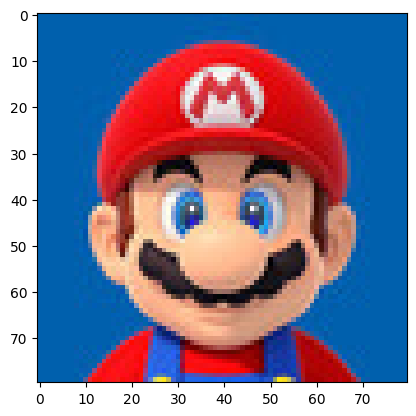

In [7]:
image = cv2.imread('mario_b.jpg')
show_img(image)

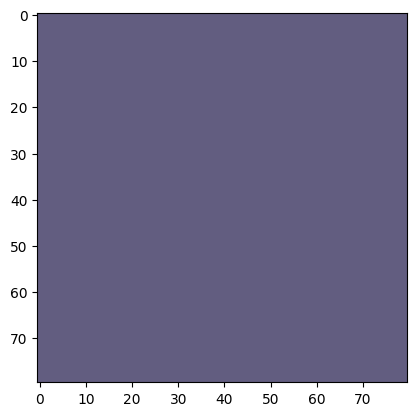

In [8]:
average_color_image = get_img_averaged(image)
show_img(average_color_image)

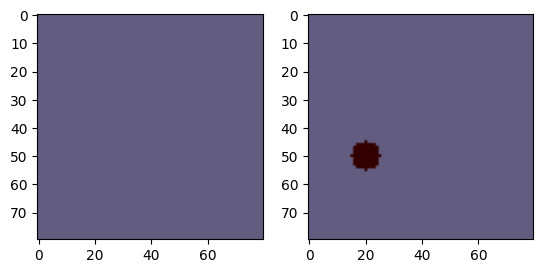

1.13484375


In [9]:
ind = [20,50,5,0,0,50,1]
img_c = draw_circle2(average_color_image, *ind)
compare_imgs(average_color_image,img_c)
print(image_difference(average_color_image, img_c))

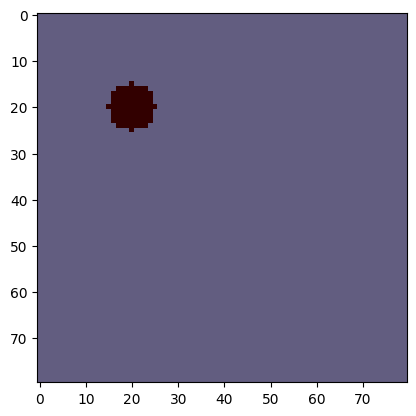

In [10]:
# res =[average_color_image]
img_w_circ = draw_circle(average_color_image, 20,20, 5, 0,0,50, 1)
plt.imshow(cv2.cvtColor(img_w_circ, cv2.COLOR_BGR2RGB))
plt.show()

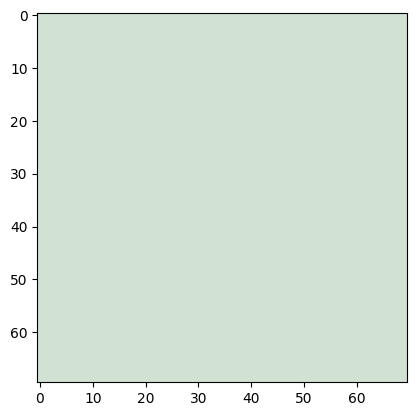

In [11]:
image_obj = cv2.imread('arbol_20.jpg')
curr_img = get_img_averaged(image_obj)
show_img(curr_img)

In [12]:
def solve(
    img_path, max_it, use_diff:bool=True,
    alpha:float=0.5, eps:float=1.0,
    verbose:bool=False, PRINT_INT:int=None
):
    if PRINT_INT is None:
        PRINT_INT = int(max_it//10)

    image_obj = cv2.imread(img_path)
    # curr_img = get_img_averaged(image_obj)
    curr_img = np.ones_like(image_obj) * 255

    i_x_len    = image_obj.shape[0]
    i_y_len    = image_obj.shape[1]

    max_r = math.sqrt( (image_obj.shape[1]**2) + image_obj.shape[0]**2 ) / 2
    min_r = max_r * 0.1
    bounds = np.array(
        [
            [0, i_x_len],
            [0, i_y_len],
            [max_r*alpha, max_r],
            [0, 255], [0, 255], [0, 255],
            [0.5, 1.0]
        ],
        dtype=float
    )


    dec_rate = (max_r-min_r) / max_it

    for i in range(max_it):
        DE = DiferentialEvolution(
            target_func, bounds, args=(curr_img, image_obj, use_diff),
            popsize=60, mutation=(0.5, 2.0), crossover=0.7,
            maxit=250, n_rep=100, verbose=False, report_interval=1
        )
        if bounds[2, 1] < 1.0: break
        # custom_de = DE_custom(target_func,bounds,args=(curr_img, image_obj),popsize=30,mutation=(0.5,1.9),crossover=0.7,maxit=100,verbose=False)
        custom_de = DE.optimize()
        # bounds[2] *= alpha
        # bounds[2] += eps
        bounds[2, 1] -= dec_rate
        bounds[2, 0] =  bounds[2,1]*alpha
        sol = custom_de['sol']

        curr_img = draw_circle(curr_img, *sol)
        
        if i%PRINT_INT == 0 and verbose:
            print(f'circle {i+1}:')
            print(f'   disp:{sol[:2]} r:{sol[2]:.2f} rgb:{sol[3:-1]} al:{sol[-1]:.2f}')
            success = custom_de['success']
            n_it    = custom_de['niter']
            print(f'fitness {target_func(sol, curr_img, image_obj, use_diff): 0.2f} success:{success} n_it:{n_it}')
            compare_imgs(image_obj, curr_img)
    # end for

    return curr_img

circle 1:
   disp:[39.59886799 39.52188761] r:56.37 rgb:[152.71600947  69.7185193    2.48598052] al:0.85
fitness  63.94 success:False n_it:250


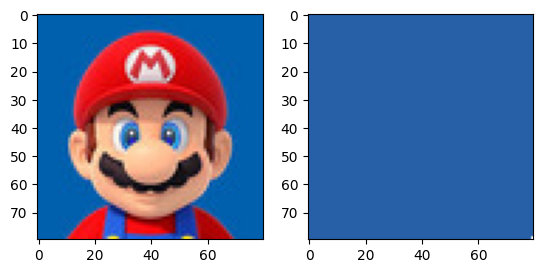

circle 51:
   disp:[0. 0.] r:25.89 rgb:[173.471563    97.19126164   0.91641655] al:0.50
fitness  32.71 success:True n_it:188


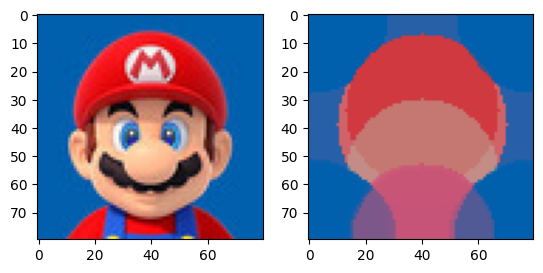

circle 101:
   disp:[39.720089 80.      ] r:24.59 rgb:[119.82183814  73.59434109 193.26099242] al:0.50
fitness  32.67 success:False n_it:250


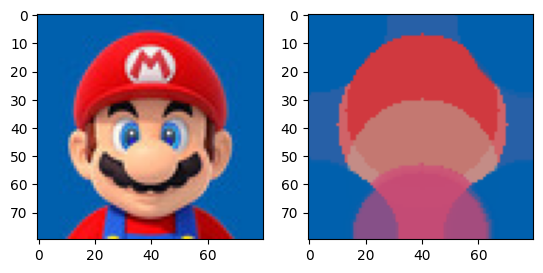

circle 151:
   disp:[80.  0.] r:20.65 rgb:[173.23590853  96.87843671   0.95776186] al:0.50
fitness  31.00 success:True n_it:151


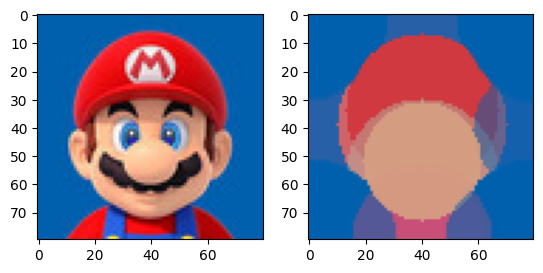

circle 201:
   disp:[0. 0.] r:18.10 rgb:[173.96354527  96.42199282   0.        ] al:0.55
fitness  29.98 success:True n_it:163


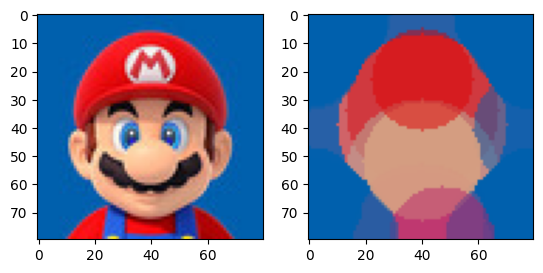

circle 251:
   disp:[80.          0.39023462] r:15.91 rgb:[173.97432749  96.45559708   0.        ] al:0.50
fitness  28.60 success:True n_it:157


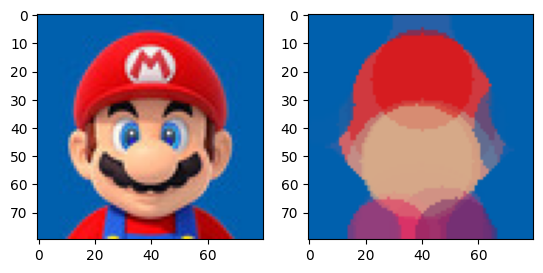

circle 301:
   disp:[80.         75.75670769] r:14.77 rgb:[173.50860984  96.15640184   0.        ] al:0.99
fitness  26.41 success:False n_it:250


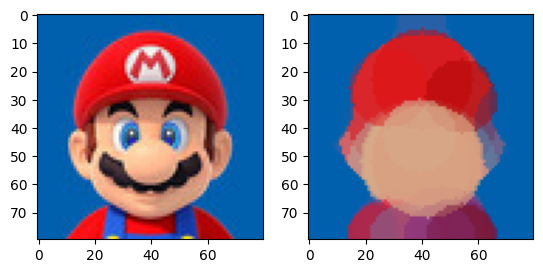

circle 351:
   disp:[ 9.96177739 65.98771038] r:10.53 rgb:[173.29412929  97.13177763   0.        ] al:0.50
fitness  23.77 success:False n_it:250


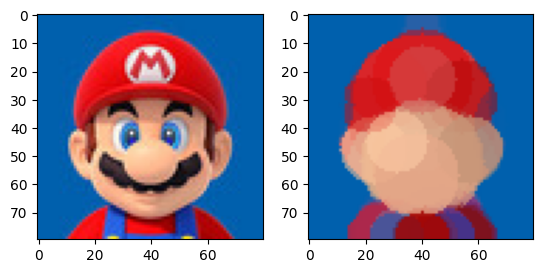

circle 401:
   disp:[18.11240827 80.        ] r:7.92 rgb:[ 18.27761585  16.42527881 255.        ] al:0.73
fitness  20.72 success:False n_it:250


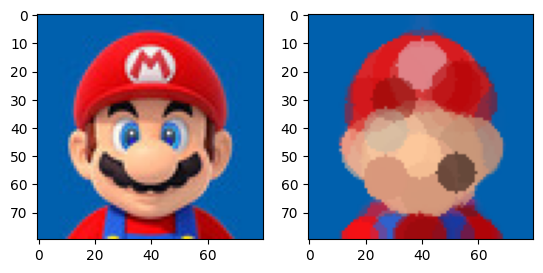

circle 451:
   disp:[40.0273267  29.34195325] r:5.37 rgb:[ 12.90224104  14.51424706 156.17493183] al:0.50
fitness  17.26 success:False n_it:250


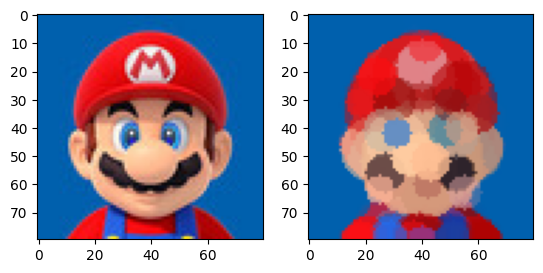

In [13]:
IMAGE_TO_SOLVE = 'mario_b.jpg'
# IMAGE_TO_SOLVE = 'arbol_20.jpg'
circle_image = solve(
	IMAGE_TO_SOLVE, 500,
	alpha=0.5, eps=0.5,
	use_diff=True,
	verbose=True, PRINT_INT=None
)

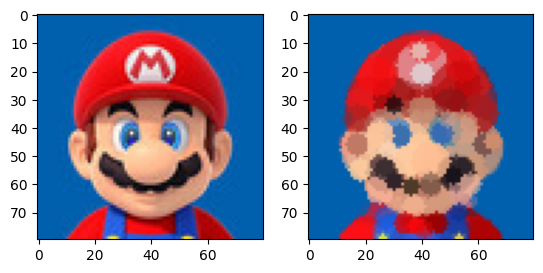

13.712447916666667


In [14]:
original_img = cv2.imread(IMAGE_TO_SOLVE)
compare_imgs(original_img, circle_image)
print(image_difference(original_img, circle_image))